In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cavsim
from cavsim import Measure
from cavsim.connectors import BaseConnector, Connector
from cavsim.channels import ImportChannel, ExportChannel
from cavsim.components import BaseComponent, Component
from cavsim.solvers import BaseSolver, SimpleSolver
from cavsim.fluids import Fluid

In [3]:
from cavsim.pipes.pipe import Pipe
from cavsim.boundaries.left_boundary_pressure import LeftBoundaryPressure
from cavsim.boundaries.left_boundary_velocity import LeftBoundaryVelocity
from cavsim.boundaries.right_boundary_pressure import RightBoundaryPressure
from cavsim.boundaries.right_boundary_velocity import RightBoundaryVelocity
from cavsim.boundaries.simple_pipe_connector import PipeConnectorSimple
from cavsim.boundaries.zeta_joint import ZetaJoint
from cavsim.boundaries.simple_t_joint import SimpleTJoint
from cavsim.boundaries.simple_right_gasdampener import RightGasBubbleSimple
from cavsim.boundaries.frictionless_gasdampener import FrictionlessGasDampener
from cavsim.boundaries.gasdampener import GasDampener
from cavsim.boundaries.pump_suction_valve import PumpSuctionValve

In [4]:
fluid = Fluid(1000, 1e-3, 2.08e9, 2.3e-3,initial_pressure=128000)

In [5]:
def pump(time):
    stroke = 0.04
    r = stroke / 2.0
    lam = 0.187
    d = 0.07
    rpm = 70
    omega = rpm / 60 * 2 * np.pi
    area = d*d / 4.0 * np.pi
    
    velocity = r * omega * (np.sin(omega * time) - (lam / 2.0) * np.sin(2* omega * time))
    result = velocity
    return result
    
    
    #return (0.045 / 2.0) * (0.07**2) * np.pi / 4.0 * np.sin(90/60*(1 * time * 2.0 * np.pi))
    #return 0.01

In [6]:
def step(time):
    return 0.35 * (time > 0.25)

In [7]:
pipe1 = Pipe(0.056, 7.0, 0.002, 2e11, 1e-7, 75)
pipe2 = Pipe(0.07, 0.5, 0.002, 2e11, 1e-7, 8)

In [8]:
lb1 = LeftBoundaryPressure(128000)
pipe1.connect(lb1)

In [9]:
rb = RightBoundaryVelocity(pump)

In [10]:
pipe2.connect(rb)

In [11]:
angle = np.pi / 2.0

In [12]:
valve = PumpSuctionValve(7850.0, 3.827, 3827.0, 0.022, 0.068, 0.041, 0.037, angle, 0.0076, 6.480, 107.00, 74.00, 1.40, -2.4, 0.50, 0.0, 0.0, 10.0e-3)
valve.connect(pipe1)
valve.connect(pipe2)

In [13]:
#valve = ZetaJoint(1.0)
#pipe1.connect(valve)
#pipe2.connect(valve)

In [14]:
plogs1 = []
plogs2 = []
vlogs = []
vlogs1 = []
flogs = []
rblogs = []
relogs = []
dislog = []
springlog = []
contact_forcelog = []
damping_force = []
upper_pforce = []
lower_pforce = []
gforce = []
flow_force = []
velocity = []
delta_p = []
zeta_field = []


def logging():
    dislog.append(valve.field_wide_slice('displacement', 1) + 0.0)
    velocity.append(valve.field_wide_slice('valve_velocity', 1) + 0.0)
    gforce.append(valve.field_wide_slice('gravity_force', 1) + 0.0)
    springlog.append(valve.field_wide_slice('spring_force', 1) + 0.0)
    upper_pforce.append(valve.field_wide_slice('upper_pressure_force', 1) + 0.0)
    lower_pforce.append(valve.field_wide_slice('lower_pressure_force', 1) + 0.0)
    damping_force.append(valve.field_wide_slice('damping_force', 1) + 0.0)
    flow_force.append(valve.field_wide_slice('flow_force', 1) + 0.0)
    contact_forcelog.append(valve.field_wide_slice('contact_pressure_force', 1) + 0.0)
    plogs1.append(pipe1.field_wide_slice('pressure', 0) + 0.0)
    plogs2.append(pipe2.field_wide_slice('pressure', 0) + 0.0)
    vlogs.append(pipe2.field_wide_slice('velocity', 0) + 0.0)
    flogs.append(pipe2.field_wide_slice('friction_steady', 0) + 0.0)
    rblogs.append(rb._velocity[0,1])
    relogs.append(pipe2.field_wide_slice('reynolds', 0) + 0.0)
    delta_p.append(valve.field_wide_slice('delta_p', 1) + 0.0)
    zeta_field.append(valve.field_wide_slice('valve_zeta', 1) + 0.0)

In [15]:
solver = SimpleSolver()
solver.fluid = fluid
solver.seeds = [pipe1, pipe2]
solver._callback = logging

In [16]:
solver.solve(1e20, 0.5, 3)

 0:00:00 [                              |  0.26%]  0:01:10  Currently at time   0.001 of   0.500

l:\cavsim\cavsim\base\solvers\simple_solver.py:46: UserWarning: Smaller timestep required by component! (7.25687327118109e-05 < 1e+20 by <cavsim.pipes.pipe.Pipe object at 0x0000029BA66B8080>)
  warn('Smaller timestep required by component! ({} < {} by {})'.format(component_time, delta_t, component))
l:\cavsim\cavsim\base\solvers\simple_solver.py:46: UserWarning: Smaller timestep required by component! (4.498865531789587e-05 < 1e+20 by <cavsim.pipes.pipe.Pipe object at 0x0000029BA65DAF60>)
  warn('Smaller timestep required by component! ({} < {} by {})'.format(component_time, delta_t, component))


 0:01:49 [==============================|100.00%]  0:00:00  Currently at time   0.500 of   0.500

In [17]:
pfield1 = np.stack(plogs1)
pfield2 = np.stack(plogs2)
vfield = np.stack(vlogs)
#ffield = np.stack(flogs)
rbfield = np.stack(rblogs)
refield = np.stack(relogs)
disfield = np.stack(dislog)
dampingfield = np.stack(damping_force)
lowp_field = np.stack(lower_pforce)
upperp_field = np.stack(upper_pforce)
contact_pressure = np.stack(contact_forcelog)
springforce = np.stack(springlog)
gfield = np.stack(gforce)
pfield2.shape
flow_field = np.stack(flow_force)
velfield = np.stack(velocity)
deltap = np.stack(delta_p)
zeta = np.stack(zeta_field)

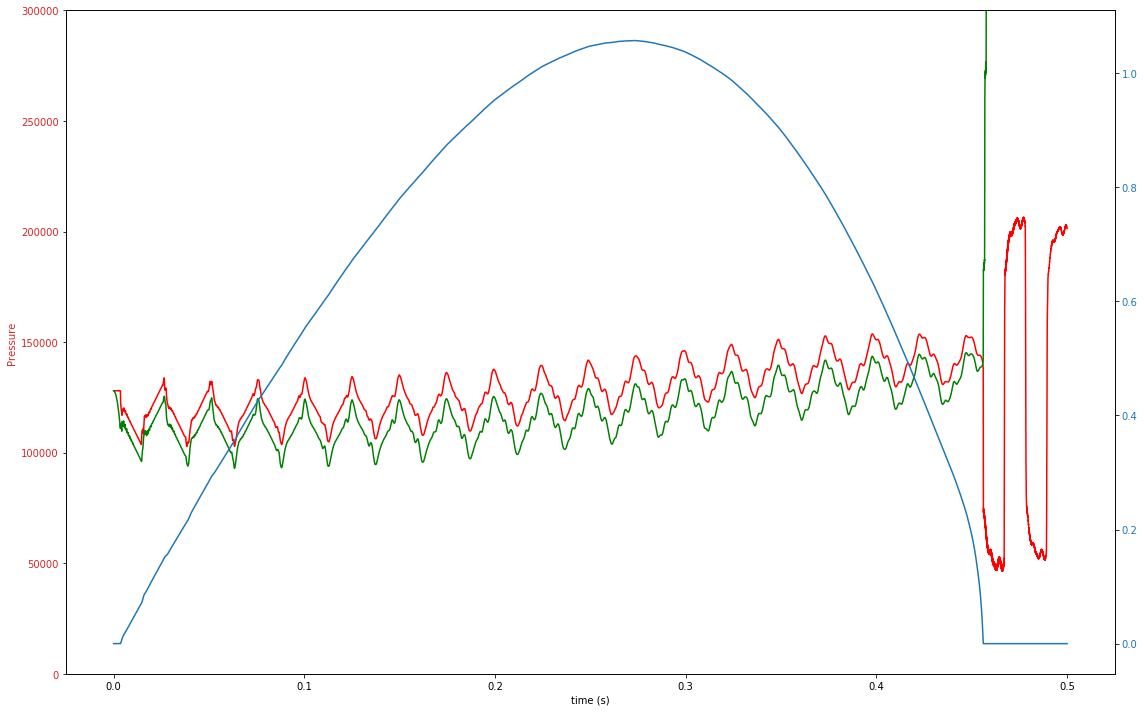

In [18]:
time = np.linspace(0, 0.5, int(pfield1[:,-2].shape[0]))
#plt.figure(figsize=(16, 10))
fig, ax1 = plt.subplots(figsize=(16, 10))
#plt.subplot(1, 2, 1)
#plt.plot(vfield[:,0])
#plt.plot(1, 2, 2)
val1 = 0
val = -1
upper_force = upperp_field[val1:val, 0] + gfield[val1:val, 0] + springforce[val1:val, 0]
lower_force = lowp_field[val1:val, 0] + contact_pressure[val1:val, 0]
result1 = lower_force - upper_force
result2 = flow_field[val1:val, 0] - gfield[val1:val, 0] - springforce[val1:val, 0] - dampingfield[val1:val, 0]
upper_flow = gfield[val1:val, 0] + springforce[val1:val, 0] + dampingfield[val1:val, 0]
lower_flow = flow_field[val1:val, 0]
#ax1.plot(time[val1:val], upper_flow, color='red')
#ax1.plot(time[val1:val], lower_flow, color='blue')


#plt.subplot(1, 2, 2)
#ax1.plot(result1[val1:val])
#ax1.plot(result2[val1:val])
#ax1.plot(time[val1:val], upperp_field[val1:val, 0], color='red')
#ax1.plot(time[val1:val], lowp_field[val1:val, 0], color='green')
#ax1.plot(time[val1:val], dampingfield[val1:val, 0], color='blue')

#ax1.plot(time[val1:val], contact_pressure[val1:val, 0], color='black')
#ax1.plot(time[val1:val], springforce[val1:val, 0], color='grey')
#ax1.plot(time[val1:val], upper_force, color='red')
#ax1.plot(time[val1:val], lower_force, color='blue')

#plt.plot(time[val1:val], pfield2[val1:val, 1], color='red')
#plt.plot(time[val1:val], pfield1[val1:val, -2])


#ax1.plot(time[val1:val], deltap[val1:val, 0], color='green')

#plt.xlim(time[val1],time[val])
#plt.ylim(-1e5, 5e5)

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Pressure', color=color)
ax1.set_ylim(0e5, 3e5)
ax1.plot(time[val1:val], pfield1[val1:val, -2], color='red')
ax1.plot(time[val1:val], pfield2[val1:val, 1], color='green')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(time[val1:val], disfield[val1:val, 0]*1e3, color=color)  # we already handled the x-label with ax1
#ax2.plot(time[val1:val], velfield[val1:val, 0], color = 'red')
#ax2.plot(time[val1:val], vfield[val1:val, 1], color = 'red')
#ax2.plot(time[val1:val], zeta[val1:val, 0], color='green')
#ax2.plot(time[val1:val], flow_field[val1:val, 0], color='black')
ax2.tick_params(axis='y', labelcolor=color)

#plt.subplot(1, 2, 1)
#plt.plot(time[val1:val], disfield[val1:val, 0]*1000, color='black')
#plt.plot(time[val1:val], velfield[val1:val, 0], color='red')
#plt.plot(time[val1:val], pfield2[val1:val, 1], color='red')
#plt.plot(time[val1:val], pfield1[val1:val, -2], color='green')
#plt.ylim(0.0e5, 8.0e5)
fig.tight_layout()
plt.show()

[   -20.28025775    -20.28025775    -20.28025775 ... -10110.0459093
 -10113.10669412 -10137.01958288]


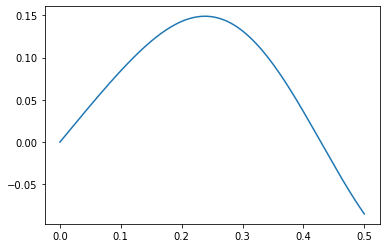

In [19]:
plt.plot(time[val1:val], pump(time[val1:val]))
#print(np.max(disfield[val1:val, 0]*1000))
print(result1)

In [20]:
valve.field('spring_force')[:3, 0]

array([0.   , 3.827, 3.827])

In [21]:
valve.field('displacement')[:, 0]

array([0., 0., 0., 0.])

In [22]:
valve.field('valve_velocity')[:3, 0]

array([0., 0., 0.])

In [23]:
valve.field('acceleration')[:3, 0]

array([0., 0., 0.])

In [24]:
valve.field('gravity_force')[:3, 0]

array([0.        , 0.77042325, 0.77042323])

In [25]:
valve.field('acceleration_force')[:3, 0]

array([0., 0., 0.])

In [26]:
valve.field('damping_force')[:3, 0]

array([0., 0., 0.])

In [27]:
valve.field('upper_pressure_force')[:3, 0]

array([    0.        , 10900.33807485, 10892.24392383])

In [28]:
valve.field('lower_pressure_force')[:3, 0]

array([  0.        , 216.74898113, 216.77521319])

In [29]:
valve.field('contact_pressure_force')[:3, 0]

array([  0.        , 543.43996967, 543.04655099])

In [30]:
valve.field('flow_force')[:3, 0]

array([0., 0., 0.])

In [31]:
valve.field('valve_zeta')[:200, 0]

array([1., 1., 1.])

In [32]:
valve._flow_constant_1

0.0076

In [33]:
valve._flow_constant_2

6.48

In [34]:
valve._valve_zeta

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [35]:
valve.field('pressure')[:3, 0]

array([128000.        , 201381.24203657, 201797.69597475])

In [36]:
pipe2.field('pressure')[:3, 1]

array([8269765.46947796, 8263301.01156938, 8243900.90337647])

In [37]:
valve._cases[2350:2375]

['Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime',
 'Flow regime']

In [38]:
valve._lower_pressure_force[:,0]

array([  0.        , 216.74898113, 216.77521319])

In [39]:
valve.field('lower_pressure_force')

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [216.74898113,   0.        ,   0.        ,   0.        ],
       [216.77521319,   0.        ,   0.        ,   0.        ]])

In [40]:
valve.field_wide_slice('lower_pressure_force', 1)

array([216.74898113,   0.        ,   0.        ,   0.        ])

In [41]:
lowp_field.shape

(11114, 4)

In [42]:
valve.calculate_lower_pressure_force()

TypeError: calculate_lower_pressure_force() missing 1 required positional argument: 'pressure'